# Imports

In [84]:
# Import necessary packages
import os 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
# import albumentations as A
# from albumentations.pytorch import ToTensor
from torch.types import Number
import sys
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image
# import albumentations as A

import time

# Constant Variables

In [192]:
# GROUND_PATH = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/DataSet/testA"
# SEGMENT_PATH = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/DataSet/testB"

# GROUND_PATH_TEST = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/DataSet/testA"
# SEGMENT_PATH_TEST = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/DataSet/testB"


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 10
LAMBDA_CYCLE = 5
# WEIGHTS_GEN_G = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Weights/GEN_G"
# WEIGHTS_GEN_S = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Weights/GEN_S"
# WEIGHTS_DISC_G = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Weights/DISC_G"
# WEIGHTS_DISC_S = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Weights/DISC_S"
# SAVE_IMAGE = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Images"


# transforms = A.Compose(
#     [
#         A.Resize(width=256, height=256),
#         A.HorizontalFlip(p=0.5),
#         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
#         ToTensor(),
#      ],
#     additional_targets={"image": "image",
#                         'image1': 'image',},
# )

# transforms2 = A.Compose(
#     [
#         A.Resize(width=256, height=256),
#         ToTensor(),
#      ],
# )
BATCH_SIZE = 1
NUM_WORKERS = 4
NUM_EPOCHS = 50

# Functions

In [ ]:

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)



# DataSet

In [177]:
from torchvision import transforms

train_data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

In [15]:
path1 = '/content/drive/MyDrive/ECE-GY 6953 DL/Project/Datasets/mini/trainA'
path2 = '/content/drive/MyDrive/ECE-GY 6953 DL/Project/Datasets/mini/trainB'

In [45]:
!mkdir ./Segment ./Ground

In [173]:

class CityscapesDataSet(Dataset):
    def __init__(self, SegmentationPath, GroundImagePath, transform=None):
        self.GroundImagePath = GroundImagePath
        self.SegmentationPath = SegmentationPath
        self.transform = transform

        self.GroundImages = os.listdir(GroundImagePath)
        self.SegmentImages = os.listdir(SegmentationPath)
        self.length_dataset = max(len(self.GroundImages), len(self.SegmentImages)) 
        self.Gr_len = len(self.GroundImages)
        self.Sg_len = len(self.SegmentImages)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        Ground = self.GroundImages[index % self.Gr_len]
        Segment = self.SegmentImages[index % self.Sg_len]

        Ground = Image.open(os.path.join(self.GroundImagePath, Ground)).convert("RGB")
        Segment = Image.open(os.path.join(self.SegmentationPath, Segment)).convert("RGB")

        if self.transform:
            Ground = self.transform(Ground)
            Segment = self.transform(Segment)
            # Ground = Ground['image']
            # Segment = Segment['image']

        return Segment, Ground

# Generator

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding, down=True, use_act=True, **kwargs):
        super().__init__()
        if down:
          self.conv1 = nn.Conv2d(in_channel, out_channel, padding_mode="reflect", kernel_size=kernel_size, padding=padding, **kwargs)
        else:
          self.conv1 = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, **kwargs)
        self.IN = nn.InstanceNorm2d(out_channel)
        if use_act:
          self.acv = nn.ReLU(inplace=True)
        else:
          self.acv = nn.Identity()
    def forward(self, x):
      x = self.conv1(x)
      x = self.IN(x)
      return  self.acv(x)

In [9]:
class ResBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.Conv1 = ConvBlock(channels, channels, kernel_size=3, padding=1)
    self.Conv2 = ConvBlock(channels, channels, kernel_size=3, padding=1, use_act=False)
  
  def forward(self, x):
    x2 = self.Conv1(x)
    x2 = self.Conv2(x2)
    return x + x2

In [10]:

class Generator(nn.Module):
  def __init__(self, img_channels, num_features=64, num_residual=9):
    super().__init__()
    self.conv1 = nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect")
    self.acv1 = nn.ReLU(inplace=True)

    self.DownBlock = nn.ModuleList([
        nn.Conv2d(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
    ])

    self.residual_blocks = nn.Sequential(
        *[ResBlock(num_features*4) for _ in range(num_residual)]
    )

    self.up_blocks = nn.ModuleList([
        ConvBlock(num_features*4, num_features*2, kernel_size=3, stride=2, padding=1, output_padding=1, down=False),
        ConvBlock(num_features*2, num_features*1, kernel_size=3, stride=2, padding=1, output_padding=1, down=False),
    ])

    self.last_layer = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

  def forward(self, x):
    x = self.conv1(x)
    x = self.acv1(x)
    for layer in self.DownBlock:
      x = layer(x)

    for layer in self.up_blocks:
      x = layer(x)
    return torch.tanh(self.last_layer(x))
    


# Discriminator

In [11]:
class DiscBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channel, out_channel, 4, stride, 1, bias=True, padding_mode="reflect")
    self.IN1 = nn.InstanceNorm2d(out_channel)
    self.act1 = nn.LeakyReLU(0.2)
  def forward(self, x):
    x = self.conv1(x)
    x = self.IN1(x)
    x = self.act1(x)
    return x

In [12]:
class Discriminator(nn.Module):
  def __init__(self, in_channel, num_features=[64, 128, 256, 512]):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channel, num_features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect")
    self.act1 = nn.LeakyReLU(0.2)

    layers = []
    in_channel = num_features[0]
    
    for counter in range(1,len(num_features)):

      layers.append(DiscBlock(in_channel, num_features[counter], stride=1 if counter==(len(num_features)-1) else 2))
      in_channel = num_features[counter]
    layers.append(nn.Conv2d(in_channel, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
    self.model = nn.Sequential(*layers)


  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.model(x)
    return torch.sigmoid(x)

   

# Train

In [155]:
def TrainCicleGAN(Disc_Ground, Gen_Seg, Disc_Seg, Gen_Ground, loader, optim_Disc, optim_Gen, L1, MSE, Disc_scaler, Gen_scaler):
  loop_prop = tqdm(loader, leave=True)
  index2 = 0
  for index, (segm, grd) in enumerate(loop_prop):
  # for index, (segm, grd) in enumerate(loader):
    grd = grd.to(DEVICE)
    segm = segm.to(DEVICE)

    H_reals = 0
    H_fakes = 0
    with torch.cuda.amp.autocast():
        print("test")
        fake_ground = Gen_Ground(segm)
        D_H_real = Disc_Ground(grd)
        D_H_fake = Disc_Ground(fake_ground.detach())
        H_reals += D_H_real.mean().item()
        H_fakes += D_H_fake.mean().item()
        D_H_real_loss = MSE(D_H_real, torch.ones_like(D_H_real))
        D_H_fake_loss = MSE(D_H_fake, torch.zeros_like(D_H_fake))
        D_H_loss = D_H_real_loss + D_H_fake_loss
       
        fake_seg = Gen_Seg(grd)
        D_Z_real = Disc_Seg(segm)
        D_Z_fake = Disc_Seg(fake_seg.detach())
        D_Z_real_loss = MSE(D_Z_real, torch.ones_like(D_Z_real))
        D_Z_fake_loss = MSE(D_Z_fake, torch.zeros_like(D_Z_fake))
        D_Z_loss = D_Z_real_loss + D_Z_fake_loss

        # put it togethor
        D_loss = (D_H_loss + D_Z_loss)/2

    optim_Disc.zero_grad()
    Disc_scaler.scale(D_loss).backward()
    Disc_scaler.step(optim_Disc)
    Disc_scaler.update()

    # Train Generators H and Z
    with torch.cuda.amp.autocast():
        # adversarial loss for both generators
        D_H_fake = Disc_Ground(fake_ground)
        D_Z_fake = Disc_Seg(fake_seg)
        loss_G_H = MSE(D_H_fake, torch.ones_like(D_H_fake))
        loss_G_Z = MSE(D_Z_fake, torch.ones_like(D_Z_fake))

        # cycle loss
        cycle_segm = Gen_Seg(fake_ground)
        cycle_ground = Gen_Ground(fake_seg)
        cycle_segm_loss = L1(segm, cycle_segm)
        cycle_ground_loss = L1(grd, cycle_ground)

        # identity loss (remove these for efficiency if you set lambda_identity=0)
        identity_segm = Gen_Seg(segm)
        identity_ground = Gen_Ground(grd)
        identity_segm_loss = L1(segm, identity_segm)
        identity_ground_loss = L1(grd, identity_ground)

        # add all togethor
        G_loss = (
            loss_G_Z
            + loss_G_H
            + cycle_segm_loss * LAMBDA_CYCLE
            + cycle_ground_loss * LAMBDA_CYCLE
            + identity_ground_loss * LAMBDA_IDENTITY
            + identity_segm_loss * LAMBDA_IDENTITY
        )

    optim_Gen.zero_grad()
    Gen_scaler.scale(G_loss).backward()
    Gen_scaler.step(optim_Gen)
    Gen_scaler.update()

    # if index2 % 200 == 0:
        # save_image(fake_ground, SAVE_IMAGE + f"/Ground/{index2}.png")
        # save_image(fake_seg, SAVE_IMAGE + f"/Segment/{index2}.png")
    save_image(fake_ground, f"./Ground/{index2}.png")
    save_image(fake_seg, f"./Segment/{index2}.png")
    index2 += 1
    loop_prop.set_postfix(H_real=H_reals/(index+1), H_fake=H_fakes/(index+1))

  return fake_ground, fake_seg



# Main Function

In [97]:
from torchvision import datasets

In [193]:

LOAD_MODEL=False
SAVE_MODEL=False


Disc_Ground = Discriminator(in_channel=3).to(DEVICE)
Disc_Seg = Discriminator(in_channel=3).to(DEVICE)
Gen_Ground = Generator(img_channels=3, num_residual=9).to(DEVICE)
Gen_Seg = Generator(img_channels=3, num_residual=9).to(DEVICE)





optim_Disc = optim.Adam(list(Disc_Ground.parameters()) + list(Disc_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)
optim_Gen = optim.Adam(list(Disc_Ground.parameters()) + list(Gen_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)

L1 = nn.L1Loss()
MSE = nn.MSELoss()
# if LOAD_MODEL:

#   Disc_Ground.load_state_dict(torch.load(WEIGHTS_DISC_G))
#   Disc_Seg.load_state_dict(torch.load(WEIGHTS_DISC_S))
#   Gen_Ground.load_state_dict(torch.load(WEIGHTS_GEN_G))
#   Gen_Seg.load_state_dict(torch.load(WEIGHTS_GEN_S))
#     # load_checkpoint(
#     #     WEIGHTS_GEN_G, Gen_Ground, optim_Gen, LEARNING_RATE,
#     # )
#     # load_checkpoint(
#     #     WEIGHTS_GEN_S, Gen_Seg, optim_Gen, LEARNING_RATE,
#     # )
#     # load_checkpoint(
#     #     WEIGHTS_DISC_G, Disc_Ground, optim_Disc, LEARNING_RATE,
#     # )
#     # load_checkpoint(
#     #     WEIGHTS_DISC_S, Disc_Seg, optim_Disc, LEARNING_RATE,
#     # )
# dataset = CityscapesDataSet(SEGMENT_PATH, GROUND_PATH, transforms2)
# test_dataset = CityscapesDataSet(SEGMENT_PATH_TEST, GROUND_PATH_TEST, transforms2)
dataset = CityscapesDataSet(path1, path2, train_data_transform)
# test_dataset = CityscapesDataSet(SEGMENT_PATH_TEST, GROUND_PATH_TEST, transforms2)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# test_loader = DataLoader(
#   test_dataset,
#   batch_size=1,
#   shuffle=False,
#   pin_memory=True,
# )

Gen_scaler = torch.cuda.amp.GradScaler()
Disc_scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    print("Epoch:", epoch)
    s_time = time.time_ns()
    x1, x2 = TrainCicleGAN(Disc_Ground, Gen_Seg, Disc_Seg, Gen_Ground, loader, optim_Disc, optim_Gen, L1, MSE, Disc_scaler, Gen_scaler)
    e_time = time.time_ns()
    print("Time elapsed: {} min".format((e_time - s_time) / 1e9 / 60))
    print()

    # if SAVE_MODEL:
    #   torch.save(Disc_Ground.state_dict(), WEIGHTS_DISC_G)
    #   torch.save(Disc_Seg.state_dict(), WEIGHTS_DISC_S)

    #   torch.save(Gen_Ground.state_dict(), WEIGHTS_GEN_G)
    #   torch.save(Gen_Seg.state_dict(), WEIGHTS_GEN_S)



Epoch: 0


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.00it/s, H_fake=0.274, H_real=0.274]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.66it/s, H_fake=0.136, H_real=0.136]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.54it/s, H_fake=0.0913, H_real=0.0913]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.89it/s, H_fake=0.069, H_real=0.0684]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.14it/s, H_fake=0.0548, H_real=0.055]

test


100%|██████████| 10/10 [00:02<00:00,  4.74it/s, H_fake=0.0548, H_real=0.055]


Time elapsed: 0.035356957333333335 min

Epoch: 1


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.20it/s, H_fake=0.276, H_real=0.279]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.76it/s, H_fake=0.138, H_real=0.142]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.55it/s, H_fake=0.0924, H_real=0.0921]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.02it/s, H_fake=0.069, H_real=0.0695]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.15it/s, H_fake=0.0553, H_real=0.0565]

test


100%|██████████| 10/10 [00:02<00:00,  4.82it/s, H_fake=0.0553, H_real=0.0565]


Time elapsed: 0.03471907813333333 min

Epoch: 2


 10%|█         | 1/10 [00:00<00:04,  2.09it/s, H_fake=0.553, H_real=0.566]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.24it/s, H_fake=0.185, H_real=0.188]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.32it/s, H_fake=0.11, H_real=0.113]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.81it/s, H_fake=0.0784, H_real=0.0797]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.10it/s, H_fake=0.0623, H_real=0.0617]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.90it/s, H_fake=0.0542, H_real=0.0552]


Time elapsed: 0.03426840668333333 min

Epoch: 3


 10%|█         | 1/10 [00:00<00:04,  2.07it/s, H_fake=0.549, H_real=0.572]

test


 20%|██        | 2/10 [00:00<00:02,  3.31it/s, H_fake=0.275, H_real=0.281]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.48it/s, H_fake=0.138, H_real=0.142]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.06it/s, H_fake=0.0924, H_real=0.0937]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.22it/s, H_fake=0.069, H_real=0.0696]

test
test


100%|██████████| 10/10 [00:02<00:00,  5.53it/s, H_fake=0.056, H_real=0.0565]

test


100%|██████████| 10/10 [00:02<00:00,  4.38it/s, H_fake=0.056, H_real=0.0565]


Time elapsed: 0.038189434683333336 min

Epoch: 4


 10%|█         | 1/10 [00:00<00:06,  1.45it/s, H_fake=0.559, H_real=0.56]

test
test


 30%|███       | 3/10 [00:01<00:02,  3.36it/s, H_fake=0.184, H_real=0.193]

test
test


 50%|█████     | 5/10 [00:01<00:01,  4.45it/s, H_fake=0.111, H_real=0.117]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.13it/s, H_fake=0.0804, H_real=0.0804]

test
test


 90%|█████████ | 9/10 [00:02<00:00,  5.40it/s, H_fake=0.0616, H_real=0.0651]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.17it/s, H_fake=0.0557, H_real=0.0565]


Time elapsed: 0.04009525525 min

Epoch: 5


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.52it/s, H_fake=0.277, H_real=0.286]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.92it/s, H_fake=0.139, H_real=0.149]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.69it/s, H_fake=0.0917, H_real=0.097]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.09it/s, H_fake=0.0694, H_real=0.0708]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.20it/s, H_fake=0.0554, H_real=0.0566]

test


100%|██████████| 10/10 [00:02<00:00,  4.94it/s, H_fake=0.0554, H_real=0.0566]


Time elapsed: 0.03388895 min

Epoch: 6


 10%|█         | 1/10 [00:00<00:04,  2.04it/s, H_fake=0.551, H_real=0.576]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.32it/s, H_fake=0.186, H_real=0.192]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.41it/s, H_fake=0.114, H_real=0.113]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.97it/s, H_fake=0.0796, H_real=0.0843]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.23it/s, H_fake=0.0612, H_real=0.0651]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.99it/s, H_fake=0.0557, H_real=0.0567]


Time elapsed: 0.0335910587 min

Epoch: 7


 10%|█         | 1/10 [00:00<00:04,  2.04it/s, H_fake=0.552, H_real=0.556]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.34it/s, H_fake=0.184, H_real=0.195]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.37it/s, H_fake=0.111, H_real=0.121]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.96it/s, H_fake=0.079, H_real=0.0824]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.26it/s, H_fake=0.062, H_real=0.0629]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.98it/s, H_fake=0.0557, H_real=0.0574]


Time elapsed: 0.03365847811666667 min

Epoch: 8


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.31it/s, H_fake=0.28, H_real=0.298]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.94it/s, H_fake=0.138, H_real=0.148]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.71it/s, H_fake=0.0925, H_real=0.102]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.09it/s, H_fake=0.0711, H_real=0.071]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.35it/s, H_fake=0.0552, H_real=0.0579]

test


100%|██████████| 10/10 [00:02<00:00,  4.96it/s, H_fake=0.0552, H_real=0.0579]


Time elapsed: 0.03372939911666666 min

Epoch: 9


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.37it/s, H_fake=0.274, H_real=0.294]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.96it/s, H_fake=0.14, H_real=0.143]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.79it/s, H_fake=0.0944, H_real=0.0948]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.13it/s, H_fake=0.0714, H_real=0.0715]

test
test


100%|██████████| 10/10 [00:01<00:00,  5.80it/s, H_fake=0.0545, H_real=0.0585]

test


100%|██████████| 10/10 [00:02<00:00,  4.65it/s, H_fake=0.0545, H_real=0.0585]


Time elapsed: 0.036060434366666665 min

Epoch: 10


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:03,  2.47it/s, H_fake=0.284, H_real=0.284]

test
test


 40%|████      | 4/10 [00:01<00:01,  3.99it/s, H_fake=0.136, H_real=0.146]

test
test


 60%|██████    | 6/10 [00:01<00:00,  4.85it/s, H_fake=0.093, H_real=0.103]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.33it/s, H_fake=0.0696, H_real=0.0718]

test
test


100%|██████████| 10/10 [00:02<00:00,  5.51it/s, H_fake=0.0555, H_real=0.0548]

test


100%|██████████| 10/10 [00:02<00:00,  4.06it/s, H_fake=0.0555, H_real=0.0548]


Time elapsed: 0.04119440185 min

Epoch: 11


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  2.71it/s, H_fake=0.281, H_real=0.301]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.43it/s, H_fake=0.138, H_real=0.146]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.44it/s, H_fake=0.0963, H_real=0.0951]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.98it/s, H_fake=0.0682, H_real=0.074]

test
test


100%|██████████| 10/10 [00:02<00:00,  6.13it/s, H_fake=0.0559, H_real=0.0622]

test


100%|██████████| 10/10 [00:02<00:00,  4.54it/s, H_fake=0.0559, H_real=0.0622]


Time elapsed: 0.03685266316666667 min

Epoch: 12


 10%|█         | 1/10 [00:00<00:04,  2.05it/s, H_fake=0.562, H_real=0.605]

test


 20%|██        | 2/10 [00:00<00:02,  3.33it/s, H_fake=0.272, H_real=0.293]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.90it/s, H_fake=0.139, H_real=0.156]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.68it/s, H_fake=0.0924, H_real=0.0911]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.10it/s, H_fake=0.0703, H_real=0.0713]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.27it/s, H_fake=0.0546, H_real=0.059]

test


100%|██████████| 10/10 [00:02<00:00,  4.91it/s, H_fake=0.0546, H_real=0.059]


Time elapsed: 0.03406553688333334 min

Epoch: 13


 10%|█         | 1/10 [00:00<00:04,  2.14it/s, H_fake=0.546, H_real=0.589]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.35it/s, H_fake=0.19, H_real=0.19]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.49it/s, H_fake=0.111, H_real=0.109]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.88it/s, H_fake=0.0806, H_real=0.0812]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.18it/s, H_fake=0.0622, H_real=0.0643]

test
test


100%|██████████| 10/10 [00:01<00:00,  5.00it/s, H_fake=0.0569, H_real=0.0573]


Time elapsed: 0.03346984671666667 min

Epoch: 14


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.31it/s, H_fake=0.275, H_real=0.293]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.92it/s, H_fake=0.14, H_real=0.152]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.73it/s, H_fake=0.0924, H_real=0.0901]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.08it/s, H_fake=0.0699, H_real=0.0725]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.33it/s, H_fake=0.0543, H_real=0.0587]

test


100%|██████████| 10/10 [00:02<00:00,  4.97it/s, H_fake=0.0543, H_real=0.0587]


Time elapsed: 0.03378670405 min

Epoch: 15


  0%|          | 0/10 [00:00<?, ?it/s, H_fake=0.577, H_real=0.573]

test


 20%|██        | 2/10 [00:00<00:02,  3.36it/s, H_fake=0.28, H_real=0.318]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.95it/s, H_fake=0.141, H_real=0.154]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.87it/s, H_fake=0.0906, H_real=0.0991]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.25it/s, H_fake=0.0673, H_real=0.0738]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.41it/s, H_fake=0.0581, H_real=0.0574]

test


100%|██████████| 10/10 [00:01<00:00,  5.02it/s, H_fake=0.0581, H_real=0.0574]


Time elapsed: 0.033420090150000005 min

Epoch: 16


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.13it/s, H_fake=0.286, H_real=0.287]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.45it/s, H_fake=0.14, H_real=0.159]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.18it/s, H_fake=0.0965, H_real=0.0941]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.45it/s, H_fake=0.0688, H_real=0.0671]

test
test


100%|██████████| 10/10 [00:02<00:00,  5.66it/s, H_fake=0.056, H_real=0.0583]

test


100%|██████████| 10/10 [00:02<00:00,  4.37it/s, H_fake=0.056, H_real=0.0583]


Time elapsed: 0.038390176783333334 min

Epoch: 17


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:03,  2.55it/s, H_fake=0.288, H_real=0.286]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.12it/s, H_fake=0.139, H_real=0.135]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.05it/s, H_fake=0.09, H_real=0.0993]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.62it/s, H_fake=0.0688, H_real=0.0738]

test
test


100%|██████████| 10/10 [00:02<00:00,  6.05it/s, H_fake=0.0572, H_real=0.0569]

test


100%|██████████| 10/10 [00:02<00:00,  4.36it/s, H_fake=0.0572, H_real=0.0569]


Time elapsed: 0.0384406771 min

Epoch: 18


 10%|█         | 1/10 [00:00<00:04,  2.08it/s, H_fake=0.571, H_real=0.57]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.38it/s, H_fake=0.189, H_real=0.206]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.46it/s, H_fake=0.111, H_real=0.119]

test
test


 70%|███████   | 7/10 [00:01<00:00,  6.00it/s, H_fake=0.0775, H_real=0.0852]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.26it/s, H_fake=0.0635, H_real=0.0635]

test
test


100%|██████████| 10/10 [00:01<00:00,  5.00it/s, H_fake=0.0542, H_real=0.0595]


Time elapsed: 0.03346585228333333 min

Epoch: 19


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.48it/s, H_fake=0.281, H_real=0.296]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.97it/s, H_fake=0.14, H_real=0.134]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.74it/s, H_fake=0.0952, H_real=0.0957]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.04it/s, H_fake=0.0702, H_real=0.0804]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.28it/s, H_fake=0.0541, H_real=0.059]

test


100%|██████████| 10/10 [00:01<00:00,  5.00it/s, H_fake=0.0541, H_real=0.059]


Time elapsed: 0.033572693 min

Epoch: 20


 10%|█         | 1/10 [00:00<00:04,  2.07it/s, H_fake=0.565, H_real=0.614]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.33it/s, H_fake=0.188, H_real=0.215]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.40it/s, H_fake=0.115, H_real=0.114]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.96it/s, H_fake=0.0804, H_real=0.0846]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.29it/s, H_fake=0.0647, H_real=0.0632]

test
test


100%|██████████| 10/10 [00:01<00:00,  5.00it/s, H_fake=0.0578, H_real=0.0574]


Time elapsed: 0.03346758256666667 min

Epoch: 21


 10%|█         | 1/10 [00:00<00:04,  2.17it/s, H_fake=0.571, H_real=0.576]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.46it/s, H_fake=0.191, H_real=0.192]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.44it/s, H_fake=0.112, H_real=0.129]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.90it/s, H_fake=0.0786, H_real=0.0763]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.28it/s, H_fake=0.0598, H_real=0.0655]

test
test


100%|██████████| 10/10 [00:01<00:00,  5.05it/s, H_fake=0.0536, H_real=0.0591]


Time elapsed: 0.0331522199 min

Epoch: 22


 10%|█         | 1/10 [00:00<00:04,  2.23it/s, H_fake=0.563, H_real=0.595]

test
test

 20%|██        | 2/10 [00:00<00:02,  3.60it/s, H_fake=0.291, H_real=0.288]


test


 40%|████      | 4/10 [00:00<00:01,  5.24it/s, H_fake=0.144, H_real=0.141]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.83it/s, H_fake=0.0933, H_real=0.0884]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.82it/s, H_fake=0.0713, H_real=0.0773]

test
test


100%|██████████| 10/10 [00:01<00:00,  5.81it/s, H_fake=0.0573, H_real=0.057]

test


100%|██████████| 10/10 [00:02<00:00,  4.76it/s, H_fake=0.0573, H_real=0.057]


Time elapsed: 0.035300328416666665 min

Epoch: 23


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:03,  2.51it/s, H_fake=0.282, H_real=0.298]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.10it/s, H_fake=0.142, H_real=0.156]

test
test


 60%|██████    | 6/10 [00:01<00:00,  4.85it/s, H_fake=0.0906, H_real=0.1]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.34it/s, H_fake=0.0705, H_real=0.0811]

test
test


100%|██████████| 10/10 [00:02<00:00,  5.72it/s, H_fake=0.0576, H_real=0.0565]

test


100%|██████████| 10/10 [00:02<00:00,  4.06it/s, H_fake=0.0576, H_real=0.0565]


Time elapsed: 0.04122540026666666 min

Epoch: 24


 10%|█         | 1/10 [00:00<00:06,  1.43it/s, H_fake=0.556, H_real=0.536]

test


 20%|██        | 2/10 [00:00<00:03,  2.59it/s, H_fake=0.276, H_real=0.3]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.38it/s, H_fake=0.142, H_real=0.155]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.31it/s, H_fake=0.0966, H_real=0.0959]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.92it/s, H_fake=0.0715, H_real=0.0709]

test
test


100%|██████████| 10/10 [00:02<00:00,  6.18it/s, H_fake=0.0535, H_real=0.0596]

test


100%|██████████| 10/10 [00:02<00:00,  4.49it/s, H_fake=0.0535, H_real=0.0596]


Time elapsed: 0.0373573277 min

Epoch: 25


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.51it/s, H_fake=0.283, H_real=0.328]

test
test


 40%|████      | 4/10 [00:00<00:01,  5.10it/s, H_fake=0.138, H_real=0.149]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.90it/s, H_fake=0.0966, H_real=0.0962]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.21it/s, H_fake=0.0702, H_real=0.0729]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.28it/s, H_fake=0.0583, H_real=0.0573]

test


100%|██████████| 10/10 [00:01<00:00,  5.05it/s, H_fake=0.0583, H_real=0.0573]


Time elapsed: 0.033170746433333335 min

Epoch: 26


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.34it/s, H_fake=0.279, H_real=0.268]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.92it/s, H_fake=0.145, H_real=0.143]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.58it/s, H_fake=0.0943, H_real=0.0994]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.09it/s, H_fake=0.069, H_real=0.0746]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.29it/s, H_fake=0.0543, H_real=0.0599]

test


100%|██████████| 10/10 [00:02<00:00,  4.93it/s, H_fake=0.0543, H_real=0.0599]


Time elapsed: 0.033963218616666666 min

Epoch: 27


 10%|█         | 1/10 [00:00<00:04,  2.13it/s, H_fake=0.585, H_real=0.576]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.38it/s, H_fake=0.186, H_real=0.178]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.49it/s, H_fake=0.108, H_real=0.12]

test
test


 70%|███████   | 7/10 [00:01<00:00,  6.00it/s, H_fake=0.0781, H_real=0.0861]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.23it/s, H_fake=0.0648, H_real=0.0635]

test
test


100%|██████████| 10/10 [00:01<00:00,  5.02it/s, H_fake=0.0567, H_real=0.0654]


Time elapsed: 0.03342220921666667 min

Epoch: 28


 10%|█         | 1/10 [00:00<00:04,  2.08it/s, H_fake=0.574, H_real=0.576]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.32it/s, H_fake=0.187, H_real=0.177]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.39it/s, H_fake=0.116, H_real=0.116]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.92it/s, H_fake=0.0808, H_real=0.084]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.20it/s, H_fake=0.0632, H_real=0.0731]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.95it/s, H_fake=0.0536, H_real=0.06]


Time elapsed: 0.03388493545 min

Epoch: 29


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  2.99it/s, H_fake=0.292, H_real=0.287]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.34it/s, H_fake=0.139, H_real=0.129]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.09it/s, H_fake=0.0885, H_real=0.0995]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.52it/s, H_fake=0.0691, H_real=0.0751]

test
test


100%|██████████| 10/10 [00:02<00:00,  5.56it/s, H_fake=0.058, H_real=0.0571]

test


100%|██████████| 10/10 [00:02<00:00,  4.33it/s, H_fake=0.058, H_real=0.0571]


Time elapsed: 0.03871079836666667 min

Epoch: 30


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:03,  2.48it/s, H_fake=0.284, H_real=0.331]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.00it/s, H_fake=0.134, H_real=0.149]

test
test


 60%|██████    | 6/10 [00:01<00:00,  4.81it/s, H_fake=0.094, H_real=0.0994]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.56it/s, H_fake=0.0667, H_real=0.0732]

test
test


100%|██████████| 10/10 [00:02<00:00,  6.01it/s, H_fake=0.0583, H_real=0.0561]

test


100%|██████████| 10/10 [00:02<00:00,  4.25it/s, H_fake=0.0583, H_real=0.0561]


Time elapsed: 0.039444460599999995 min

Epoch: 31


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.36it/s, H_fake=0.268, H_real=0.301]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.91it/s, H_fake=0.143, H_real=0.15]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.73it/s, H_fake=0.0959, H_real=0.0964]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.11it/s, H_fake=0.0693, H_real=0.0748]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.29it/s, H_fake=0.0573, H_real=0.0624]

test


100%|██████████| 10/10 [00:02<00:00,  4.94it/s, H_fake=0.0573, H_real=0.0624]


Time elapsed: 0.03381210553333334 min

Epoch: 32


 10%|█         | 1/10 [00:00<00:03,  2.27it/s, H_fake=0.539, H_real=0.602]

test
test

 20%|██        | 2/10 [00:00<00:02,  3.62it/s, H_fake=0.287, H_real=0.313]


test


 40%|████      | 4/10 [00:00<00:01,  5.12it/s, H_fake=0.145, H_real=0.144]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.75it/s, H_fake=0.0946, H_real=0.1]

test
test


 80%|████████  | 8/10 [00:01<00:00,  6.10it/s, H_fake=0.0728, H_real=0.0699]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.28it/s, H_fake=0.0552, H_real=0.0598]

test


100%|██████████| 10/10 [00:01<00:00,  5.07it/s, H_fake=0.0552, H_real=0.0598]


Time elapsed: 0.033048634283333336 min

Epoch: 33


 10%|█         | 1/10 [00:00<00:04,  2.13it/s, H_fake=0.572, H_real=0.626]

test


 20%|██        | 2/10 [00:00<00:02,  3.44it/s, H_fake=0.277, H_real=0.3]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.94it/s, H_fake=0.145, H_real=0.142]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.69it/s, H_fake=0.0968, H_real=0.096]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.89it/s, H_fake=0.0702, H_real=0.0657]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.17it/s, H_fake=0.0575, H_real=0.0577]

test


100%|██████████| 10/10 [00:02<00:00,  4.90it/s, H_fake=0.0575, H_real=0.0577]


Time elapsed: 0.034197173766666665 min

Epoch: 34


 10%|█         | 1/10 [00:00<00:04,  2.12it/s, H_fake=0.583, H_real=0.581]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.31it/s, H_fake=0.189, H_real=0.196]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.36it/s, H_fake=0.11, H_real=0.119]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.78it/s, H_fake=0.0832, H_real=0.0804]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.12it/s, H_fake=0.0595, H_real=0.0654]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.92it/s, H_fake=0.0587, H_real=0.0568]


Time elapsed: 0.03410407155 min

Epoch: 35


 10%|█         | 1/10 [00:00<00:04,  2.05it/s, H_fake=0.569, H_real=0.528]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.31it/s, H_fake=0.197, H_real=0.19]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.35it/s, H_fake=0.11, H_real=0.121]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.42it/s, H_fake=0.0826, H_real=0.0903]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  5.63it/s, H_fake=0.0639, H_real=0.0739]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.58it/s, H_fake=0.0537, H_real=0.0591]


Time elapsed: 0.0366083557 min

Epoch: 36


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:03,  2.52it/s, H_fake=0.274, H_real=0.303]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.01it/s, H_fake=0.147, H_real=0.141]

test
test


 60%|██████    | 6/10 [00:01<00:00,  4.67it/s, H_fake=0.0955, H_real=0.104]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.17it/s, H_fake=0.0729, H_real=0.0717]

test
test


100%|██████████| 10/10 [00:02<00:00,  5.41it/s, H_fake=0.0559, H_real=0.051]

test


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, H_fake=0.0559, H_real=0.051]


Time elapsed: 0.04206703385 min

Epoch: 37


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  2.74it/s, H_fake=0.287, H_real=0.312]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.43it/s, H_fake=0.132, H_real=0.147]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.31it/s, H_fake=0.0919, H_real=0.0999]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.81it/s, H_fake=0.072, H_real=0.0721]

test
test


100%|██████████| 10/10 [00:02<00:00,  6.02it/s, H_fake=0.0541, H_real=0.0603]

test


100%|██████████| 10/10 [00:02<00:00,  4.52it/s, H_fake=0.0541, H_real=0.0603]


Time elapsed: 0.03708457108333333 min

Epoch: 38


 10%|█         | 1/10 [00:00<00:04,  2.15it/s, H_fake=0.579, H_real=0.58]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.29it/s, H_fake=0.19, H_real=0.174]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.30it/s, H_fake=0.111, H_real=0.121]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.81it/s, H_fake=0.0815, H_real=0.0854]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.07it/s, H_fake=0.0653, H_real=0.0641]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.91it/s, H_fake=0.0548, H_real=0.0607]


Time elapsed: 0.034213705600000005 min

Epoch: 39


 10%|█         | 1/10 [00:00<00:04,  2.08it/s, H_fake=0.587, H_real=0.569]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.25it/s, H_fake=0.18, H_real=0.199]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.30it/s, H_fake=0.119, H_real=0.117]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.78it/s, H_fake=0.0848, H_real=0.0814]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.03it/s, H_fake=0.0637, H_real=0.0743]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.89it/s, H_fake=0.0557, H_real=0.0604]


Time elapsed: 0.0342329319 min

Epoch: 40


  0%|          | 0/10 [00:00<?, ?it/s, H_fake=0.578, H_real=0.578]

test


 20%|██        | 2/10 [00:00<00:02,  3.30it/s, H_fake=0.288, H_real=0.313]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.89it/s, H_fake=0.139, H_real=0.151]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.59it/s, H_fake=0.0915, H_real=0.102]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.96it/s, H_fake=0.0719, H_real=0.0835]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.11it/s, H_fake=0.0569, H_real=0.0601]

test


100%|██████████| 10/10 [00:02<00:00,  4.86it/s, H_fake=0.0569, H_real=0.0601]


Time elapsed: 0.03463664615 min

Epoch: 41


 10%|█         | 1/10 [00:00<00:04,  2.02it/s, H_fake=0.576, H_real=0.629]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.26it/s, H_fake=0.193, H_real=0.191]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.30it/s, H_fake=0.109, H_real=0.122]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.84it/s, H_fake=0.0811, H_real=0.0734]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.09it/s, H_fake=0.0654, H_real=0.0624]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.85it/s, H_fake=0.0557, H_real=0.0604]


Time elapsed: 0.0345661273 min

Epoch: 42


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:03,  2.48it/s, H_fake=0.266, H_real=0.299]

test
test


 40%|████      | 4/10 [00:01<00:01,  3.90it/s, H_fake=0.144, H_real=0.13]

test
test


 60%|██████    | 6/10 [00:01<00:00,  4.75it/s, H_fake=0.0964, H_real=0.111]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.22it/s, H_fake=0.0714, H_real=0.0752]

test
test


100%|██████████| 10/10 [00:02<00:00,  5.45it/s, H_fake=0.0589, H_real=0.0566]

test


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, H_fake=0.0589, H_real=0.0566]


Time elapsed: 0.042009416900000006 min

Epoch: 43


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:03,  2.55it/s, H_fake=0.288, H_real=0.313]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.05it/s, H_fake=0.143, H_real=0.167]

test
test


 60%|██████    | 6/10 [00:01<00:00,  4.93it/s, H_fake=0.0898, H_real=0.101]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.64it/s, H_fake=0.0657, H_real=0.0732]

test
test


100%|██████████| 10/10 [00:02<00:00,  6.05it/s, H_fake=0.059, H_real=0.0566]

test


100%|██████████| 10/10 [00:02<00:00,  4.32it/s, H_fake=0.059, H_real=0.0566]


Time elapsed: 0.03889713213333333 min

Epoch: 44


 10%|█         | 1/10 [00:00<00:04,  2.04it/s, H_fake=0.546, H_real=0.611]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.19it/s, H_fake=0.19, H_real=0.173]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.28it/s, H_fake=0.119, H_real=0.116]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.84it/s, H_fake=0.0828, H_real=0.0896]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.10it/s, H_fake=0.0621, H_real=0.0671]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.88it/s, H_fake=0.0538, H_real=0.0592]


Time elapsed: 0.0343271597 min

Epoch: 45


 10%|█         | 1/10 [00:00<00:04,  2.03it/s, H_fake=0.531, H_real=0.595]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.23it/s, H_fake=0.193, H_real=0.19]

test
test


 50%|█████     | 5/10 [00:01<00:00,  5.20it/s, H_fake=0.115, H_real=0.104]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.84it/s, H_fake=0.0823, H_real=0.0859]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  6.15it/s, H_fake=0.0664, H_real=0.0627]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.87it/s, H_fake=0.0579, H_real=0.0669]


Time elapsed: 0.034419730999999995 min

Epoch: 46


 10%|█         | 1/10 [00:00<00:04,  2.01it/s, H_fake=0.54, H_real=0.592]

test


 20%|██        | 2/10 [00:00<00:02,  3.31it/s, H_fake=0.288, H_real=0.26]

test
test


 40%|████      | 4/10 [00:00<00:01,  4.86it/s, H_fake=0.143, H_real=0.168]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.63it/s, H_fake=0.0983, H_real=0.0945]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.95it/s, H_fake=0.0735, H_real=0.0721]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.18it/s, H_fake=0.0569, H_real=0.06]

test


100%|██████████| 10/10 [00:02<00:00,  4.86it/s, H_fake=0.0569, H_real=0.06]


Time elapsed: 0.034591475516666664 min

Epoch: 47


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:02,  3.14it/s, H_fake=0.289, H_real=0.288]

test
test


 40%|████      | 4/10 [00:01<00:01,  4.71it/s, H_fake=0.136, H_real=0.153]

test
test


 60%|██████    | 6/10 [00:01<00:00,  5.46it/s, H_fake=0.0955, H_real=0.101]

test
test


 80%|████████  | 8/10 [00:01<00:00,  5.96it/s, H_fake=0.0668, H_real=0.0733]

test
test


100%|██████████| 10/10 [00:01<00:00,  6.20it/s, H_fake=0.0565, H_real=0.0503]

test


100%|██████████| 10/10 [00:02<00:00,  4.77it/s, H_fake=0.0565, H_real=0.0503]


Time elapsed: 0.035120766016666666 min

Epoch: 48


 10%|█         | 1/10 [00:00<00:04,  1.98it/s, H_fake=0.571, H_real=0.671]

test
test


 30%|███       | 3/10 [00:00<00:01,  4.22it/s, H_fake=0.183, H_real=0.203]

test
test


 50%|█████     | 5/10 [00:01<00:01,  4.92it/s, H_fake=0.114, H_real=0.101]

test
test


 70%|███████   | 7/10 [00:01<00:00,  5.31it/s, H_fake=0.0849, H_real=0.0826]

test
test


 90%|█████████ | 9/10 [00:01<00:00,  5.48it/s, H_fake=0.0653, H_real=0.0642]

test
test


100%|██████████| 10/10 [00:02<00:00,  4.37it/s, H_fake=0.0573, H_real=0.0604]


Time elapsed: 0.03852223035 min

Epoch: 49


  0%|          | 0/10 [00:00<?, ?it/s]

test


 20%|██        | 2/10 [00:00<00:03,  2.44it/s, H_fake=0.297, H_real=0.284]

test
test


 40%|████      | 4/10 [00:01<00:01,  3.85it/s, H_fake=0.149, H_real=0.142]

test
test


 60%|██████    | 6/10 [00:01<00:00,  4.62it/s, H_fake=0.0928, H_real=0.101]

test
test


 80%|████████  | 8/10 [00:02<00:00,  4.96it/s, H_fake=0.071, H_real=0.0636]

test
test


100%|██████████| 10/10 [00:02<00:00,  5.07it/s, H_fake=0.0539, H_real=0.0588]

test


100%|██████████| 10/10 [00:02<00:00,  3.91it/s, H_fake=0.0539, H_real=0.0588]

Time elapsed: 0.0427437882 min



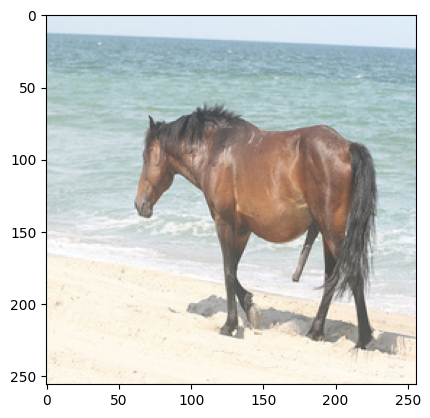

In [182]:
tmpimg = Image.open('/content/drive/MyDrive/ECE-GY 6953 DL/Project/Datasets/mini/trainA/n02381460_1127.jpg')
# tmpimg = train_data_transform(tmpimg).permute(1,2,0)
plt.imshow(tmpimg)

(256, 256, 3)


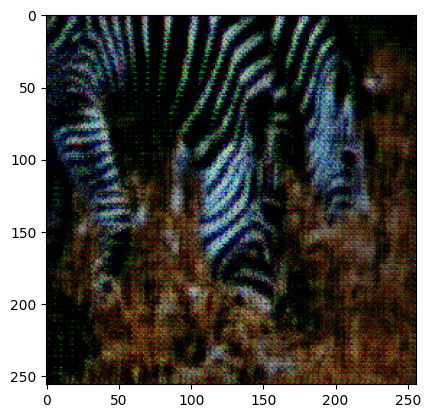

In [205]:
path = '/content/Segment/0.png'
# path = '/content/drive/MyDrive/ECE-GY 6953 DL/Project/Datasets/mini/trainA/n02381460_1127.jpg'
img = Image.open(path)
print(np.array(img).shape)
plt.imshow(img)

### Other

In [ ]:
# Gen_Ground = Generator(img_channels=3, num_residual=9)
# Gen_Ground.load_state_dict(torch.load(WEIGHTS_GEN_G))

RuntimeError: ignored

In [ ]:
dataset[0]

(tensor([[[0.0000, 0.0745, 0.0078,  ..., 0.0000, 0.0706, 0.0000],
          [0.0667, 0.2000, 0.1804,  ..., 0.2824, 0.3333, 0.1412],
          [0.0824, 0.2627, 0.2902,  ..., 0.4157, 0.4510, 0.1451],
          ...,
          [0.1686, 0.4000, 0.4275,  ..., 0.8039, 0.7961, 0.4745],
          [0.1725, 0.3098, 0.3137,  ..., 0.5569, 0.5373, 0.3373],
          [0.0549, 0.1020, 0.0863,  ..., 0.2196, 0.1686, 0.1255]],
 
         [[0.0078, 0.0824, 0.0078,  ..., 0.0549, 0.1216, 0.0431],
          [0.0745, 0.2078, 0.1804,  ..., 0.3529, 0.3961, 0.2000],
          [0.0902, 0.2706, 0.2902,  ..., 0.5020, 0.5333, 0.2235],
          ...,
          [0.0588, 0.2824, 0.2902,  ..., 0.2549, 0.2941, 0.0039],
          [0.0902, 0.2196, 0.2039,  ..., 0.1882, 0.2196, 0.0549],
          [0.0000, 0.0314, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0706, 0.0078,  ..., 0.0000, 0.0431, 0.0000],
          [0.0549, 0.1961, 0.1804,  ..., 0.2039, 0.2549, 0.0784],
          [0.0706, 0.2588, 0.2902,  ...,

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [ ]:
Ground = np.array(Image.open("/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Images/Segment/1000.png").convert("RGB"))

In [ ]:
im_rgb = cv2.cvtColor(Ground, cv2.COLOR_BGR2RGB)

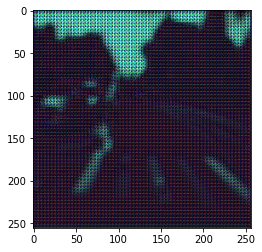

In [ ]:
imgplot = plt.imshow(Ground)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


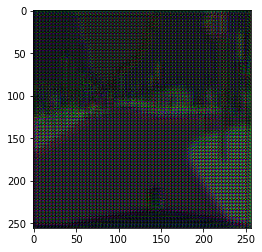

In [ ]:


imgplot = plt.imshow((fuck.permute(1, 2, 0)).detach().numpy())
plt.show()

In [ ]:
shit = (fuck.permute(1, 2, 0)).detach().numpy()

In [ ]:
np.min()

0.00030595064

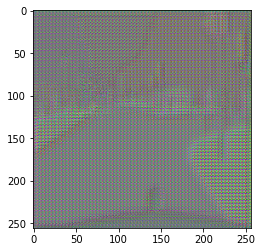

In [ ]:
imgplot = plt.imshow((shit+0.91)/2)
plt.show()